In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [3]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch

import numpy as np
from tqdm.auto import tqdm

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from decode import MidiDecoder
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from fractions import Fraction


val_dataset = ShiftedAlignedScore(is_valid= True,
                            valid_measure_num = [i for i in range(99, 104)],
                            slice_measure_num=4,
                            min_meas=4)

# val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
# valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)


In [7]:
config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'

save_name = 'vanilla_seq2seq_bestacc'
# state = torch.load('outputs/2023-12-12/04-46-10/best_model.pt')
state = torch.load('outputs/2023-12-13/11-19-42/best_pitch_sim_model.pt')
modelA = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
modelA.is_condition_shifted = True
modelA.load_state_dict(state)
modelA.eval()

# Non Pitch Modification
state = torch.load('outputs/2023-12-13/21-03-27/best_model.pt')
modelB = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
modelB.is_condition_shifted = True

modelB.load_state_dict(state)
modelB.eval()

# Non Shift
state = torch.load('outputs/2023-12-13/20-56-15/best_model.pt')
modelC = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
modelC.load_state_dict(state)
modelC.eval()
# state = torch.load('best_model.pt')

decoder = MidiDecoder(val_dataset.tokenizer)


In [8]:
model_input[0]

tensor([5, 1, 1, 3, 3, 3])

Source era: 5
Target era: 6
Line 654: tensor([[6, 1, 1, 3, 3, 3]])
Line 654: tensor([[6, 1, 1, 3, 3, 3]])


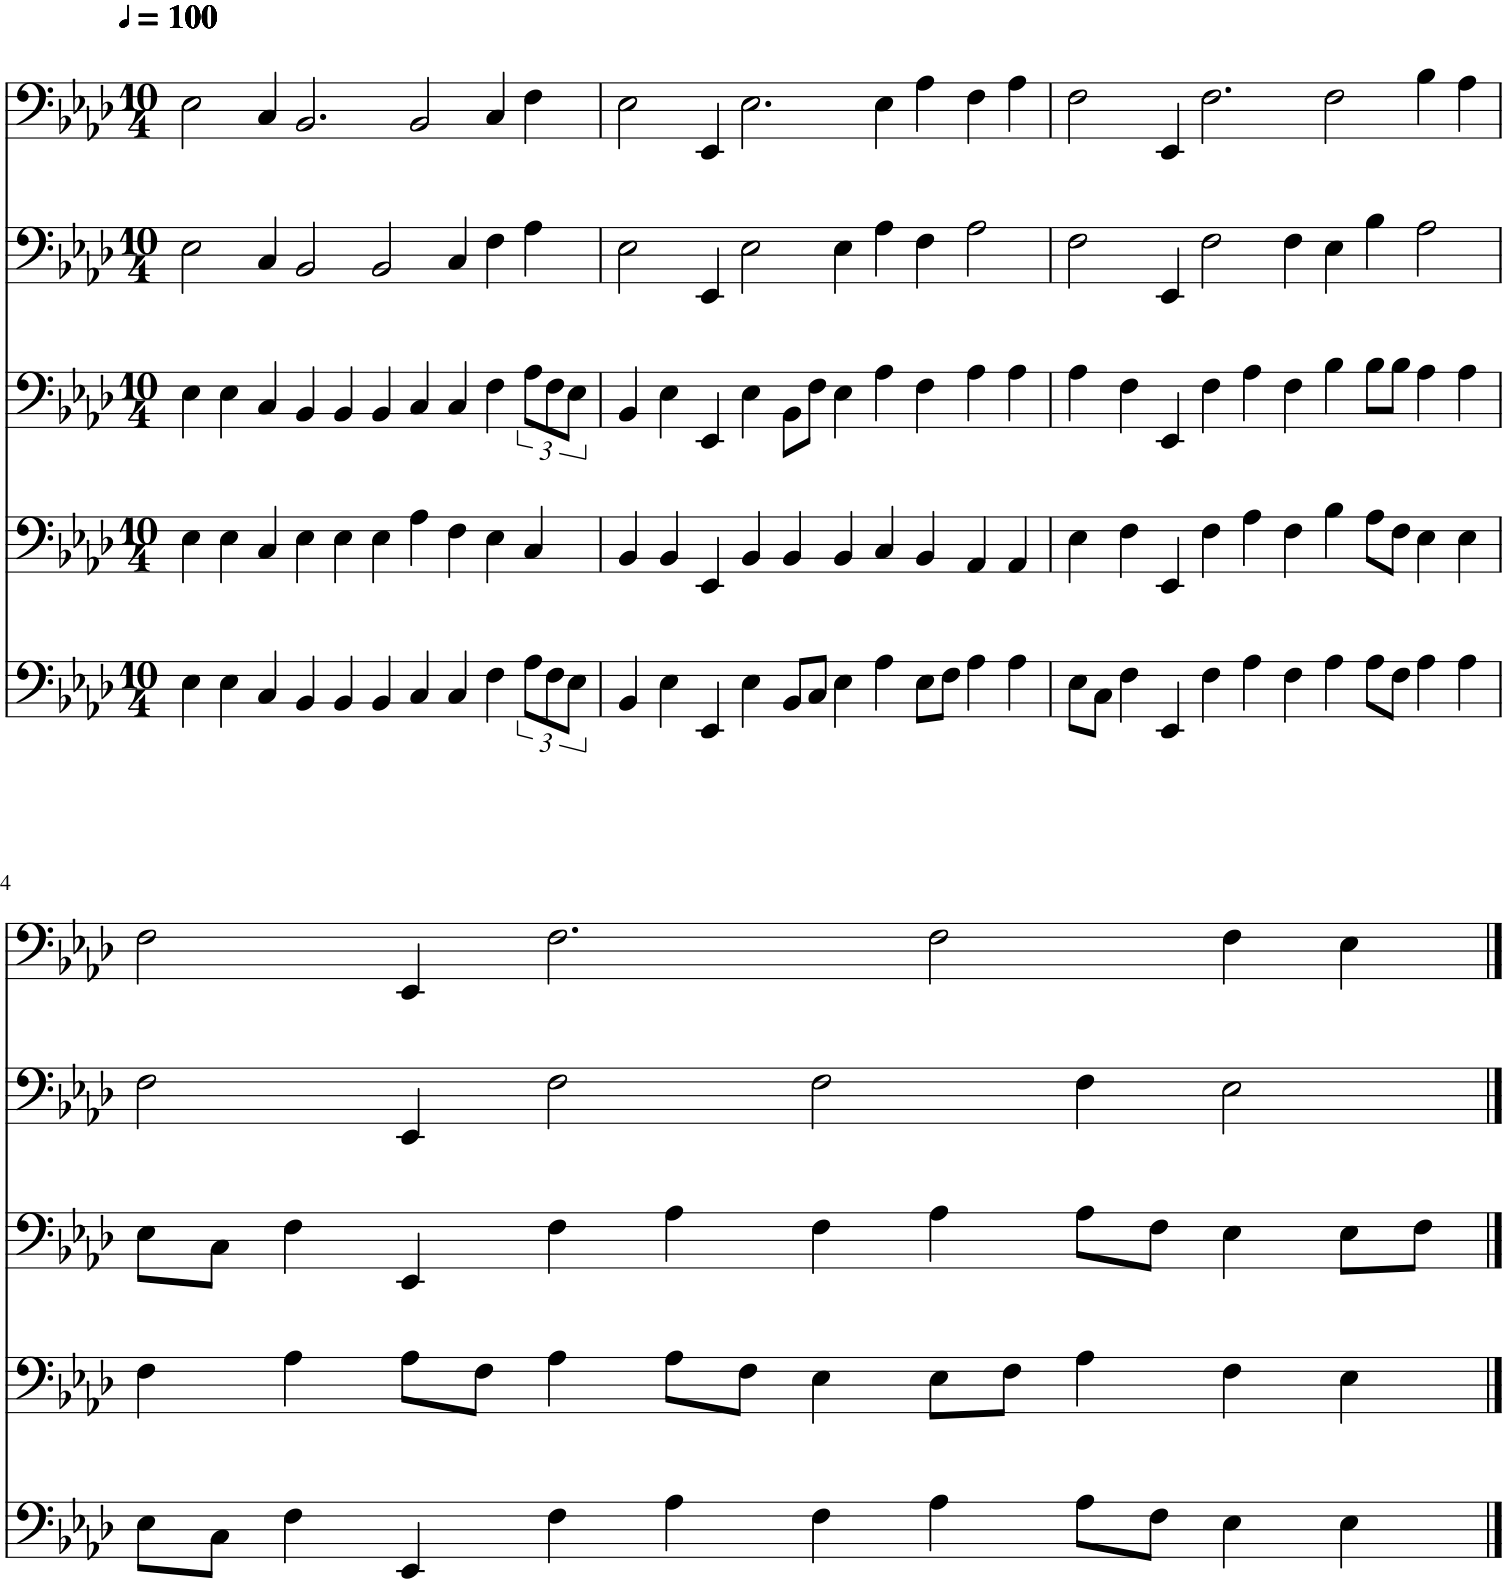

In [13]:
idx = 6

sample, model_input, gt = val_dataset[idx]
input_idx = sample[0, 0]
target_idx = gt[0, 0]
print(f"Source era: {sample[0, 0]}"), print(f"Target era: {target_idx}")
src, output, (attn_map, out, new_out) = modelA.shifted_inference(sample, part_idx=target_idx)

_, outputB, (attn_mapB, _, _) = modelB.shifted_inference(sample, part_idx=target_idx)
_, outputC, attn_mapC = modelC.inference(sample, part_idx=target_idx)

score = stream.Score()
score.insert(0, decoder(src))
score.insert(0, decoder(modelA.converter(gt[:-1])))
score.insert(0, decoder(output))
score.insert(0, decoder(outputB))
score.insert(0, decoder(outputC))

score.show()

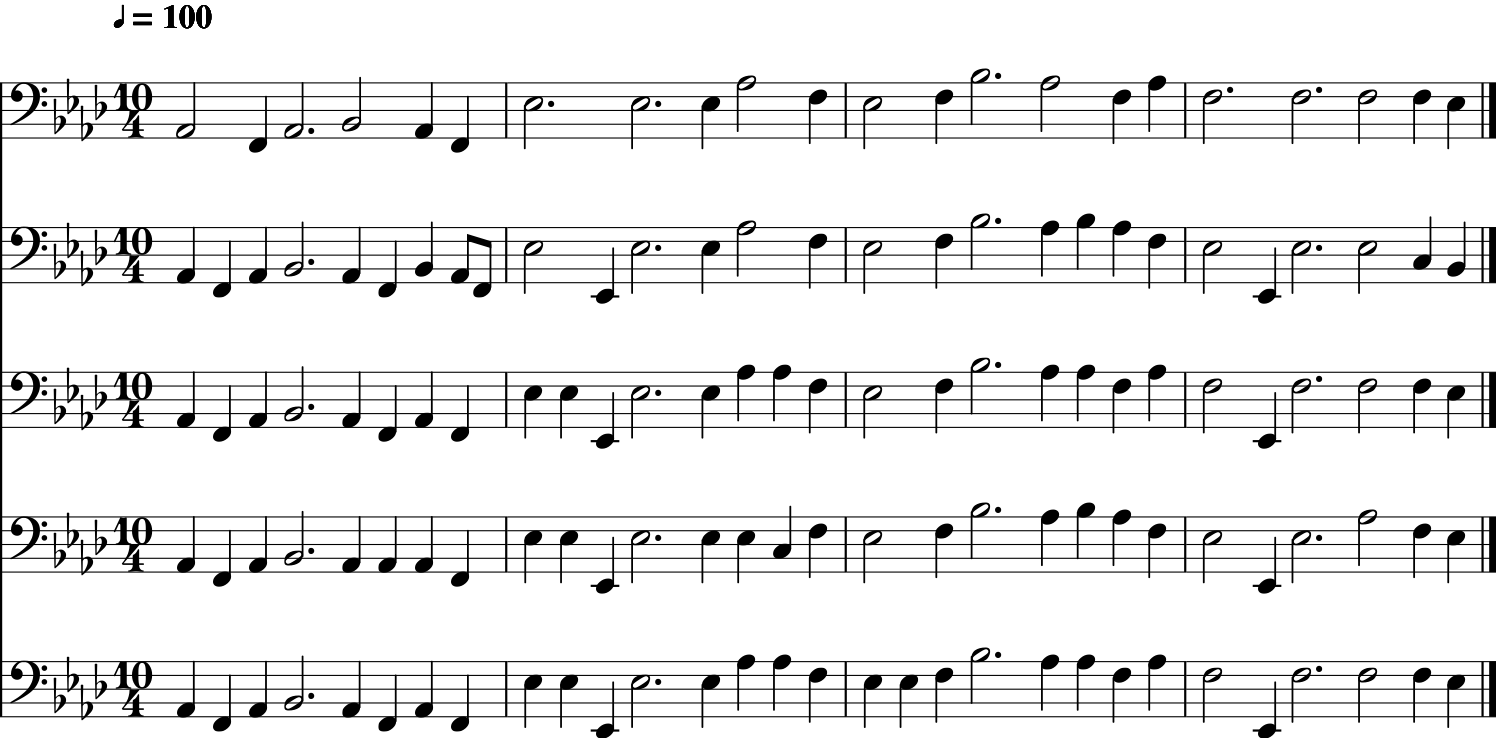

Text(0.5, 1.0, 'No Position Shift')

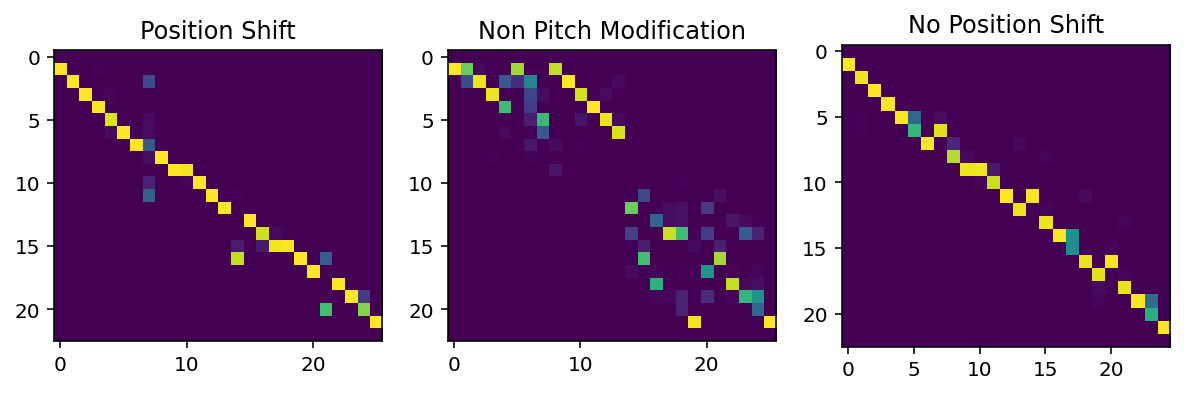

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.imshow(attn_map)
plt.title('Position Shift')
plt.subplot(1, 3, 2)
plt.imshow(attn_mapB)
plt.title('Non Pitch Modification')
plt.subplot(1, 3, 3)
plt.imshow(attn_mapC)
plt.title('No Position Shift')
